This notebook is a slight modification of 🤗 Hugging Face's [introduction to diffusion models](https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb).

You can find the full course [here](https://github.com/huggingface/diffusion-models-class).

# Tutorial on Diffusion Models with 🤗


In this notebook, you'll train your first diffusion model to **generate images of cute butterflies 🦋.** Along the way, you'll learn about the core components of the 🤗 Diffusers library, a useful library for working with diffusion models.

Let's dive in!

## Step 1: Setup

Run the following cell to install the diffusers library as well as a few other requirements:

In [ ]:
%pip install -qq -U diffusers datasets

Let's import the libraries we'll be using and define a few convenience functions which we'll use later in the notebook:

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OK, we're all set!

Recall that training a diffusion model looks something like this:


1.   Load in some images from the training data
2.   Add noise, in different amounts.
3.   Feed the noisy versions of the inputs into the model
4.   Evaluate how well the model does at denoising these inputs
5.   Use this information to update the model weights, and repeat

We'll explore these steps one by one in the next few sections until we have a complete training loop working, and then we'll explore how to sample from the trained model. Let's begin with the data...

## Step 1: Download a training dataset

For this example, we'll use a dataset of images from the Hugging Face Hub. Specifically, [this collection of 1000 butterfly pictures](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset). This is a very small dataset, so we've also included commented out lines for a few larger options. If you'd prefer to use your own collection of images, you can also use the commented-out code example to load in pictures from a folder instead.

In [ ]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Or load images from a local folder
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

We can grab a batch of images and view some of them like so:

X shape: torch.Size([8, 3, 32, 32])


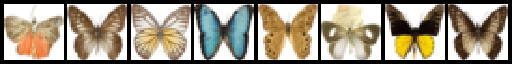

In [ ]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

We're sticking to a small dataset with 32 pixel images to keep training times manageable in this notebook.

## Step 2: Define the Scheduler

Our plan for training is to take these input images and add noise to them, then feed the noisy images to the model. And during inference, we will use the model predictions to iteratively remove noise. In `diffusers`,  these processes are both handled by the **scheduler**.

The noise schedule determines how much noise is added at different timesteps. Here's how we might create a scheduler using the default settings for 'DDPM' training and sampling (based on the paper ["Denoising Diffusion Probabilistic Models"](https://arxiv.org/abs/2006.11239)):

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

The DDPM paper describes a corruption process that adds a small amount of noise for every 'timestep'. Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = {N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t according to some schedule, and determines how much noise is added per timestep. Now, we don't necessarily want to do this operation 500 times to get $x_{500}$ so we have another formula to get $x_t$ for any t given $x_0$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= {N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

The maths notation always looks scary! Luckily the scheduler handles all that for us. We can plot $\sqrt{\bar{\alpha}_t}$ (labelled as `sqrt_alpha_prod`) and $\sqrt{(1 - \bar{\alpha}_t)}$ (labelled as `sqrt_one_minus_alpha_prod`) to view how the input (x) and the noise are scaled and mixed across different timesteps:

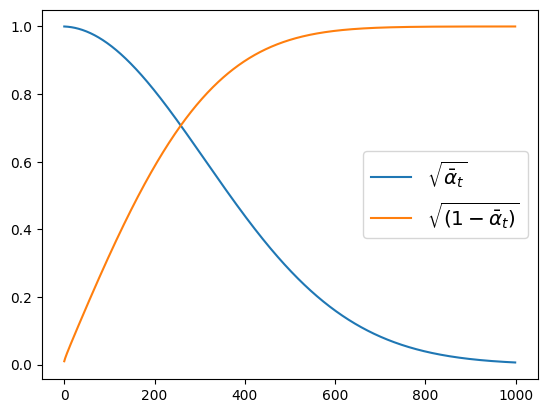

In [ ]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

**Exercise:** You can explore how this plot changes with different settings for beta_start, beta_end and beta_schedule by swapping in one of the commented-out options here:

In [ ]:
# One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
# The 'cosine' schedule, which may be better for small image sizes:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
noise_scheduler.alphas_cumprod.cpu()[-1]

tensor(4.0358e-05)

Whichever scheduler you've chosen, we can now use it to add noise in different amounts using the `noise_scheduler.add_noise` function like so:

Noisy X shape torch.Size([8, 3, 32, 32])


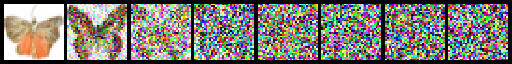

In [ ]:
# T = 1000
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

Noisy X shape torch.Size([8, 3, 32, 32])


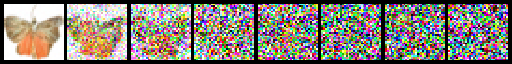

In [ ]:
xc = torch.reshape(xb[0].repeat(8,1,1), (8, 3, 32, 32))
noisy_xc = noise_scheduler.add_noise(xc, noise, timesteps)
print("Noisy X shape", noisy_xc.shape)
show_images(noisy_xc).resize((8 * 64, 64), resample=Image.NEAREST)

You can explore the effect of using different noise schedules and parameters here.

## Step 3: Define the Model

Now we come to the core component: the model itself.

Most diffusion models use architectures that are some variant of a [U-net](https://arxiv.org/abs/1505.04597) and that's what we'll use here.

<!--
![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)
-->

In a nutshell:
- the model has the input image go through several blocks of ResNet layers, each of which halves the image size by 2
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downsample path to the corresponding layers in the upsample path.

A key feature of this model is that it predicts images of the same size as the input, which is exactly what we need here.

Diffusers provides us a handy `UNet2DModel` class which creates the desired architecture in PyTorch.

Let's create a U-net for our desired image size.
Note that `down_block_types` correspond to the downsampling blocks (green on the diagram above), and `up_block_types` are the upsampling blocks (red on the diagram):

In [ ]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

When dealing with higher-resolution inputs you may want to use more down and up-blocks, and keep the attention layers only at the lowest resolution (bottom) layers to reduce memory usage. We'll talk later about how you might experiment to find the best settings for your use-case.

We can check that passing in a batch of data and some random timesteps produces an output the same shape as the input data:

In [ ]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

In the next section we'll see how to train this model.

## Step 4: Create a Training Loop

Time to train! Below is a typical optimization loop in PyTorch, where we run through the data batch by batch and update the parameters of our model each step using an optimizer - in this case the AdamW optimizer with a learning rate of 0.0004.

For each batch of data, we
- Sample some random timesteps
- Noise the data accordingly
- Feed the noisy data through the model
- Compare the model predictions with the target (i.e. the noise in this case) using mean squared error as our loss function
- Update the model parameters via `loss.backward()` and `optimizer.step()`

During this process we also log the losses over time for later plotting.

Caution: This code takes nearly 10 minutes to run.

The [official diffusers training example](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb) trains a larger model on this dataset at higher resolution, and is a good reference for what a less minimal training loop looks like:

In [ ]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:5, loss: 0.1431522686034441
Epoch:10, loss: 0.11015346832573414
Epoch:15, loss: 0.09554987028241158
Epoch:20, loss: 0.08297585602849722
Epoch:25, loss: 0.07854658528231084
Epoch:30, loss: 0.07450381154194474


Plotting the loss, we see that the model rapidly improves initially and then continues to get better at a slower rate (which is more obvious if we use a log scale as shown on the right):

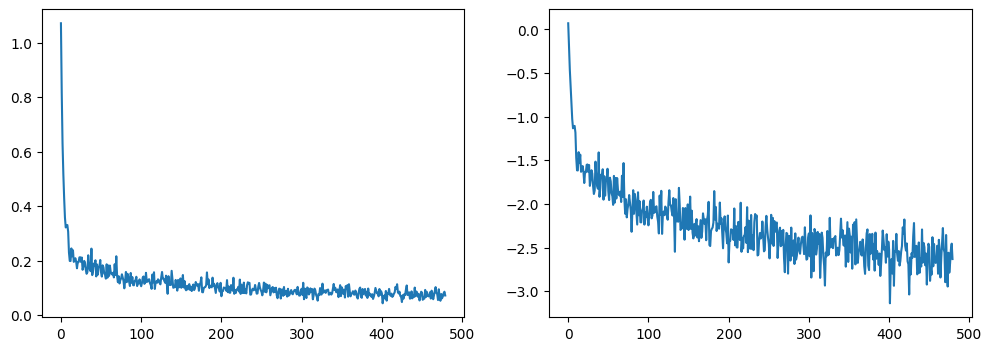

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

## Step 5: Generate Images

How do we get images with this model?

We begin with random noise, and run through the scheduler timesteps from most to least noisy, removing a small amount of noise each step based on the model prediction:

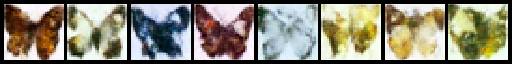

In [ ]:
# Random starting point (8 random images):
j=0
sample = torch.randn(8, 3, 32, 32).to(device)
all_samples = torch.randn(8, 8, 3, 32, 32).to(device)
time_idx = set([0, 100, 200, 350, 500, 650, 800, 999]);

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample
    if i in time_idx:
      all_samples[j, :] = sample.clone()
      j += 1

show_images(sample).resize((8 * 64, 64), resample=Image.NEAREST)

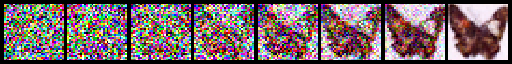

In [ ]:
im_col = 3
show_images(all_samples[:, im_col]).resize((8 * 64, 64), resample=Image.NEAREST)

The `noise_scheduler.step()` function does the maths required to update `sample` appropriately. There are a number of sampling methods - in the next unit we'll see how we can swap in a different sampler to speed up image generation with existing models, and talk more about the theory behind sampling from diffusion models.

# Avenues for Further Exploration

Hopefully this has given you a taste of what you can do with the 🤗 Diffusers library! Some possible next steps:

- Try training an unconditional diffusion model on a new dataset - bonus points if you [create one yourself](https://huggingface.co/docs/datasets/image_dataset). You can find some great image datasets for this task in the [HugGan organization](https://huggingface.co/huggan) on the Hub. Just make sure you downsample them if you don't want to wait a very long time for the model to train!
- Try out DreamBooth to create your own customized Stable Diffusion pipeline using either [this Space](https://huggingface.co/spaces/multimodalart/dreambooth-training) or [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_dreambooth_training.ipynb)
- Modify the training script to explore different UNet hyperparameters (number of layers, channels etc), different noise schedules etc.
- Check out the [Diffusion Models from Scratch](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch.ipynb) notebook for a different take on the core ideas we've covered in this unit

Good luck!